<a href="https://colab.research.google.com/github/mwelland/Wyrm/blob/main/demos/Allen_Cahn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration of Allen-Cahn phase-field model

In [1]:
#Install Firedrake if not installed
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

from firedrake.pyplot import tripcolor
import matplotlib.pyplot as plt

In [2]:
# Parameters
interface_width = .01
interface_energy = 1
interface_mobility = 50

dt = Constant(1e-1)
t0 = 0
t_final = 1

In [3]:
# Create a mesh with resolution of approximately the interface width
mesh_resolution = int(1/(2*interface_width))
mesh = UnitSquareMesh(mesh_resolution, mesh_resolution)

x = SpatialCoordinate(mesh)

In [4]:
# Define the function space and instanciate the function and test_functions
V = FunctionSpace(mesh, "CG", 1, name="phase")

phase = Function(V)
phase_old = Function(V) # Used to store previous time step
test_phase = TestFunction(V)

# Phase field model

Here we implement the Allen-Cahn phase field model using the double well potential and the gradient energy terms. Note the driving force is the variational derivative of the energy by phase. This can be calculated manually and implemented or computed using the 'derivative' funciton.

The system is spontaneously minimizes the free energy $F(A)$ which is a function of the interface area $A$. It therefore follows

\begin{align*}
d F &= \frac{\partial F}{\partial A} dA \\
 &= \gamma \ dA
\end{align*}
where $\gamma \equiv \frac{\partial F}{\partial A}$ is the interfacial energy.

In phase-field modelling, the area of the interface is represented as a functional of the phase-indicator,

\begin{align*}
A(\phi) &= \phi^2 [1-\phi]^2 + d ||\nabla \phi ||^2 \\
\end{align*}
or
\begin{align*}
dF &= \gamma \frac{\delta A}{\delta \phi} d\phi
\end{align*}

Therefore, the system is driven to reduce the free energy via reducing its interfacial energy via changing the phase-indicator:

\begin{align*}
\frac{\partial \phi}{\partial t} &\propto - \frac{d F}{d \phi} \\
&= -M_\phi \gamma \frac{\delta A}{\delta \phi}
\end{align*}


In [5]:
# Phase field functions
g_phase = phase**2*(1-phase)**2
interface_area = 3*( interface_width**2*inner(grad(phase),grad(phase)) + g_phase)

dA = derivative(interface_area, phase, test_phase)

# Equivilantly, the derivative can be written out manually:
# dg_phase = 2*phase*(1-3*phase+2*phase**2)
# dA = 3*(2*interface_width**2*inner(grad(test_phase), grad(phase)) + dg_phase*test_phase)

F_phase_interface = - interface_mobility* interface_energy * dA

F = (phase-phase_old)*test_phase - dt*F_phase_interface
F = F*dx

In [6]:
# Set initial condition to be a circle in the middle of the mesh
t = t0

def tanh_profile(x):
  return .5*(1.-tanh(x/(2.*interface_width)))

def bubble(r, centre):
  c = as_vector(centre)
  d = sqrt(inner(x-c, x-c))
  return tanh_profile(d - r)

bub1 = bubble(r = .3, centre = [.5,.5])

phase.interpolate(bub1)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7b2e637dfad0>, FiniteElement('Lagrange', triangle, 1), name='phase'), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 3)

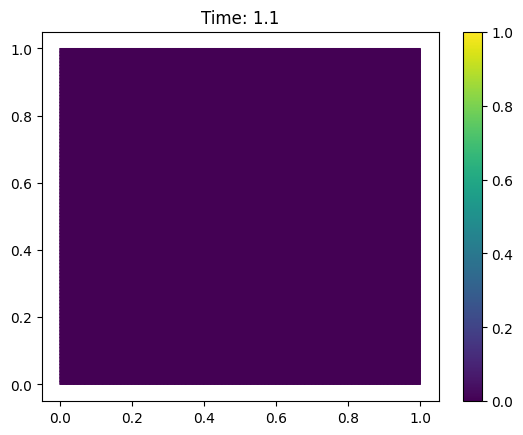

In [9]:
# Use tripcolor and set vmin and vmax for the color mapping
# TODO: Improve the performance of this funciton and make an interactive annimation.

def plot_phase(t):
  fig, axes = plt.subplots()
  colors = tripcolor(phase, axes=axes, vmin=0, vmax=1)
  axes.set_title(f"Time: {round(t,1)}")
  fig.colorbar(colors)
  plt.show()

plot_phase(t)

Current Time: 1.00e-01


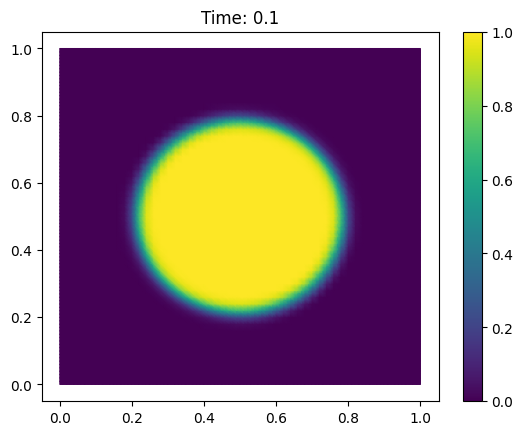

Current Time: 2.00e-01


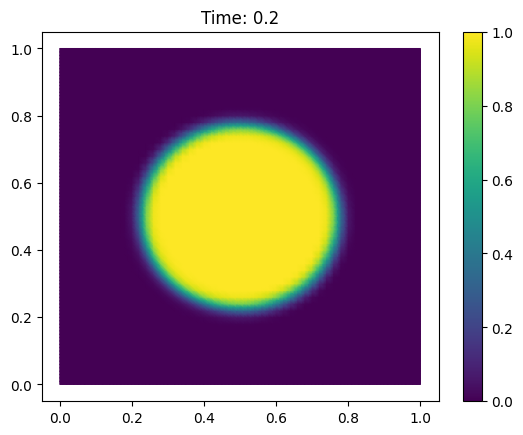

Current Time: 3.00e-01


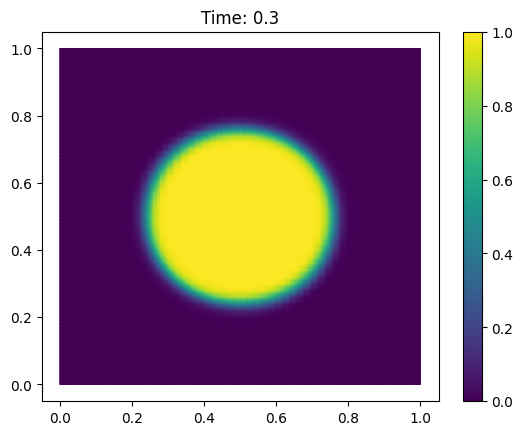

Current Time: 4.00e-01


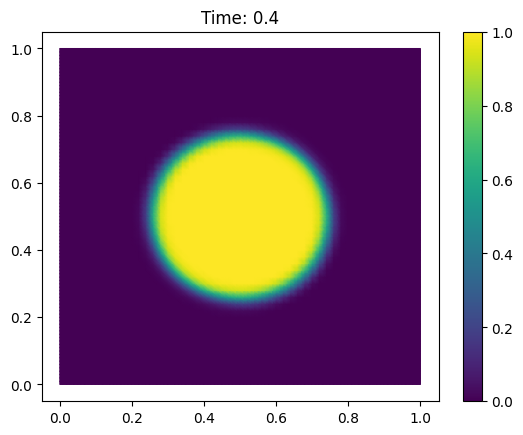

Current Time: 5.00e-01


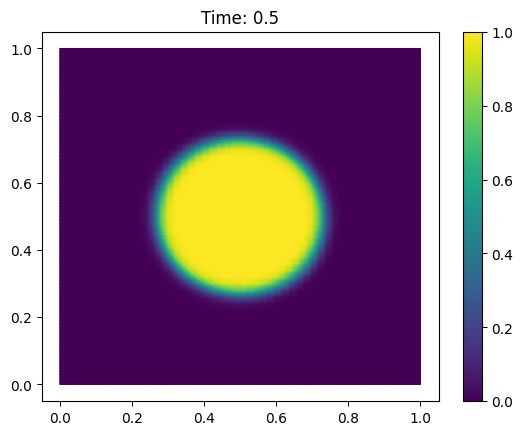

Current Time: 6.00e-01


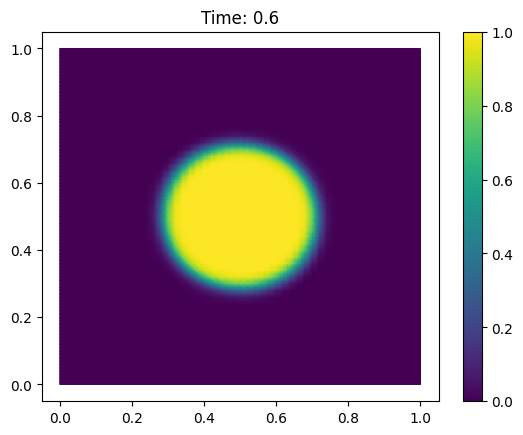

Current Time: 7.00e-01


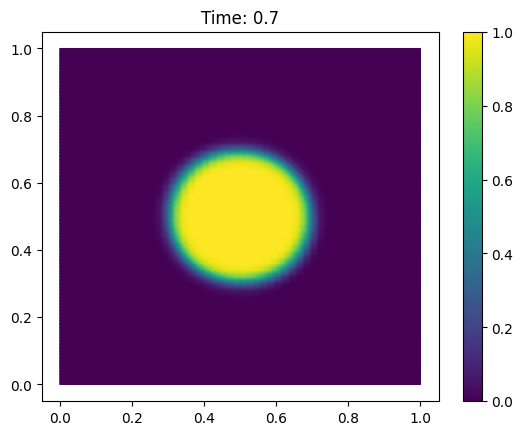

Current Time: 8.00e-01


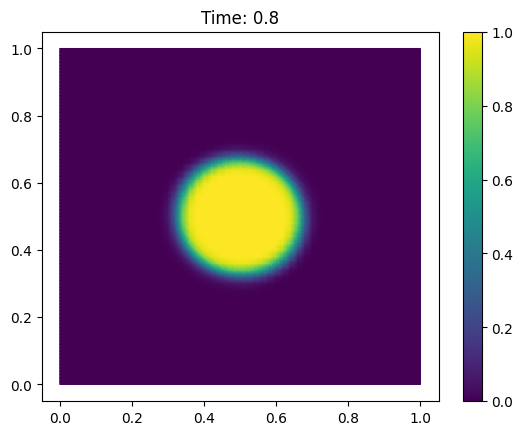

Current Time: 9.00e-01


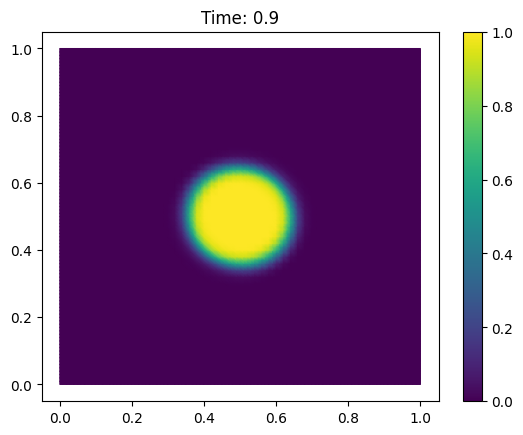

Current Time: 1.00e+00


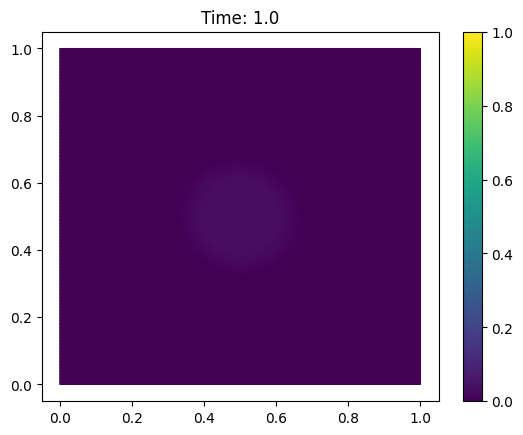

Current Time: 1.10e+00


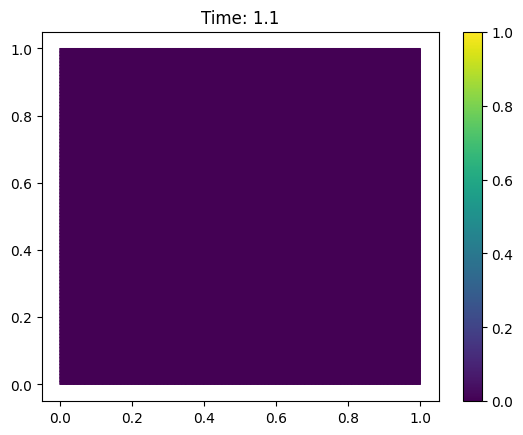

In [8]:
while t<t_final:
    phase_old.assign(phase)
    t += dt(0)
    print(f"Current Time: {round(t,2):.2e}")

    solve(F == 0, phase, solver_parameters={"ksp_type": "preonly", "pc_type": "lu"})
    plot_phase(t)